# Airlines Customer Satisfaction
### This notebook trains a CatBoost classifier to predict customer satisfaction based on various airline features.

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### classifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [53]:
!pip install catboost


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

#### Loading Data

In [55]:
DF = pd.read_csv("airlines_dataset.csv")

In [56]:
DF.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [57]:
DF.shape

(129880, 23)

In [58]:
side_by_side(DF.isnull().sum(), DF.count())

satisfaction                           0    satisfaction                         129880
Gender                                 0    Gender                               129880
Customer Type                          0    Customer Type                        129880
Age                                    0    Age                                  129880
Type of Travel                         0    Type of Travel                       129880
Class                                  0    Class                                129880
Flight Distance                        0    Flight Distance                      129880
Seat comfort                           0    Seat comfort                         129880
Departure/Arrival time convenient      0    Departure/Arrival time convenient    129880
Food and drink                         0    Food and drink                       129880
Gate location                          0    Gate location                        129880
Inflight wifi service           

In [59]:
DF[['Class']].groupby(['Class']).size()

Class
Business    62160
Eco         58309
Eco Plus     9411
dtype: int64

#### Label Encoding

In [60]:
## satisfaction column - label encoding
satisfaction_mapping = {"satisfied": 1, "dissatisfied": 0}
DF['satisfaction'] = DF['satisfaction'].map(satisfaction_mapping)

## Gender column - label encoding
gender_mapping = {"Female": 1, "Male": 0}
DF['Gender'] = DF['Gender'].map(gender_mapping)

## Customer type column - label encoding
customer_type_mapping = {"Loyal Customer": 1, "disloyal Customer": 0}
DF['Customer Type'] = DF['Customer Type'].map(customer_type_mapping)

## Type of travel column - label encoding
travel_type_mapping = {"Business travel": 2, "Personal Travel": 1}
DF['Type of Travel'] = DF['Type of Travel'].map(travel_type_mapping)

## Class column - label encoding
class_mapping = {"Business": 3, "Eco Plus": 2, "Eco": 1}
DF['Class'] = DF['Class'].map(class_mapping)

#### Catigorical Features

In [61]:
DF.nunique() ## how many unique values does each feature have?

satisfaction                            2
Gender                                  2
Customer Type                           2
Age                                    75
Type of Travel                          2
Class                                   3
Flight Distance                      5398
Seat comfort                            6
Departure/Arrival time convenient       6
Food and drink                          6
Gate location                           6
Inflight wifi service                   6
Inflight entertainment                  6
Online support                          6
Ease of Online booking                  6
On-board service                        6
Leg room service                        6
Baggage handling                        5
Checkin service                         6
Cleanliness                             6
Online boarding                         6
Departure Delay in Minutes            466
Arrival Delay in Minutes              472
dtype: int64

In [62]:
DF.columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype='object')

In [63]:
cat_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort',
               'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
               'Inflight wifi service', 'Inflight entertainment', 'Online support',
               'Ease of Online booking', 'On-board service', 'Leg room service',
               'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

target = 'satisfaction'

#### Check Class Balance

Counts of each class
satisfaction
1    71087
0    58793
Name: count, dtype: int64


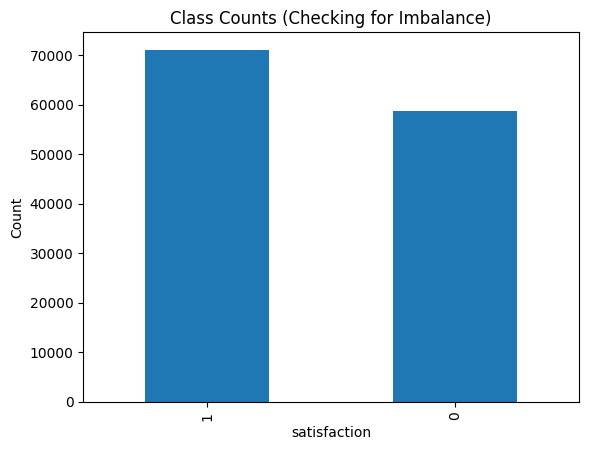

In [64]:
print("Counts of each class")
print(DF[target].value_counts())
DF[target].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
plt.show()

Classes are almost balanced

#### Missing Value Handling

> Most of the models can handle missing values: catboost, xgboost, etc, Therefore I did not handle missing features

In [65]:
print("Percentage of missing: {} %".format(round(DF['Arrival Delay in Minutes'].isnull().sum()/
                                                 DF.shape[0]*100, 3)))

Percentage of missing: 0.303 %


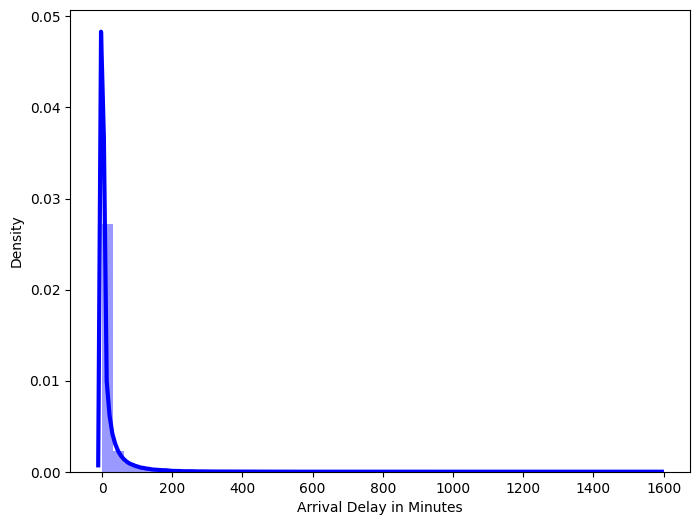

In [66]:
### We have only missing values on "Arrival Delay in Minutes" feature

fig = plt.figure(figsize=(8,6))
sns.distplot(DF['Arrival Delay in Minutes'], kde_kws={'linewidth': 3, 'color': 'blue'}, hist_kws={'color': 'blue'});
plt.show()

This feature has outliers as well

#### Splitting dataset into train, validation and test

In [67]:
X = DF.drop([target], axis=1)
y = DF[target]

In [68]:
SEED = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED)

#### Validation

In [69]:
SEED = 42
VAL_SIZE = 0.2 # % of train data

X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=VAL_SIZE, stratify=y_train, random_state=SEED)

#### Baseline model: catboost

In [70]:
# You can optimize the iterations, learning rate and also evaluation metrics
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=['Accuracy'],
    eval_metric='Accuracy'
)

# Fit the model without plot=True to avoid widget issues
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    logging_level='Silent'
)

# Print the training and validation accuracy after fitting
print("Training accuracy:", round(model.score(X_train, y_train), 3))
print("Validation accuracy:", round(model.score(X_val, y_val), 3))

Training accuracy: 0.934
Validation accuracy: 0.933
Validation accuracy: 0.933


#### Evaluation on test dataset

In [71]:
score = model.score(X_test, y_test)

print("Test score (accuracy): ", round(score, 3))

Test score (accuracy):  0.933


With basic hyperparameters we can get high result 93%, it means the dataset is simple enough

#### Explainability with Shap

> First, let's install and import SHAP for model interpretability

In [72]:
# Install SHAP if not already installed
# !pip install shap

# Import SHAP
import shap

In [73]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
base_value = explainer.expected_value

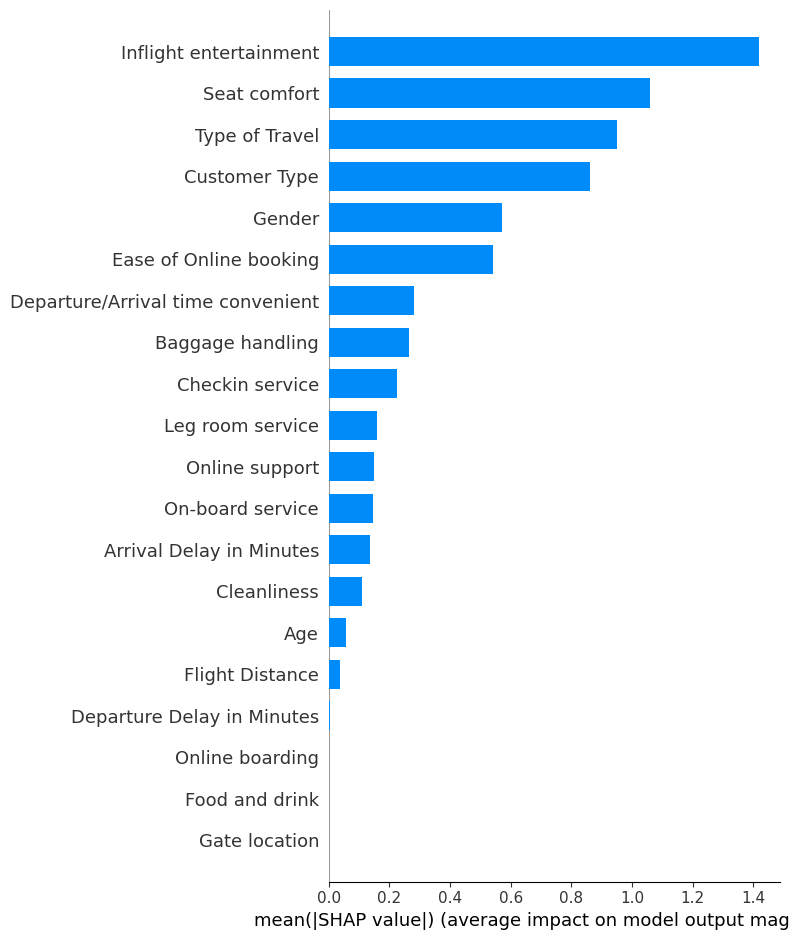

In [74]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

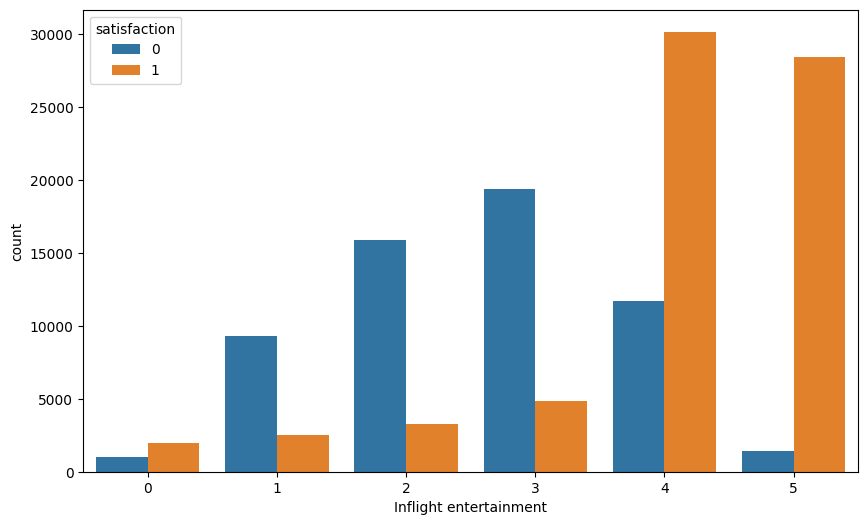

In [75]:
plt.figure(figsize=(10, 6))

x = 'Inflight entertainment'
y = target

sns.countplot(x=x, hue=y, data=DF)
plt.show()

> For "Inflight entertainment", passengers with Inflight entertainment score 4 and 5 are mostly satisfied.

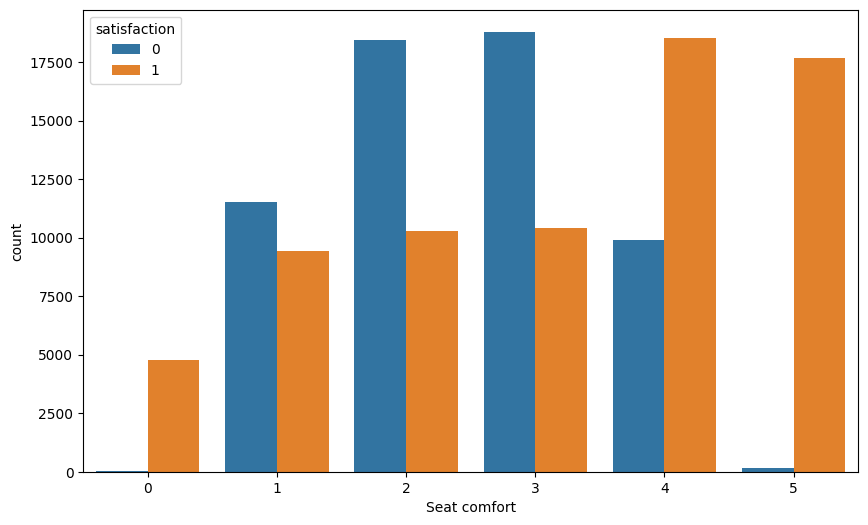

In [76]:
plt.figure(figsize=(10, 6))

x = 'Seat comfort'
y = target

sns.countplot(x=x, hue=y, data=DF)
plt.show()

For seat comfort scores of 4 and 5, the majority of customers are satisfied.
This indicates that "Seat comfort" is a significant factor influencing customer satisfaction, with higher comfort ratings strongly correlated with higher satisfaction.

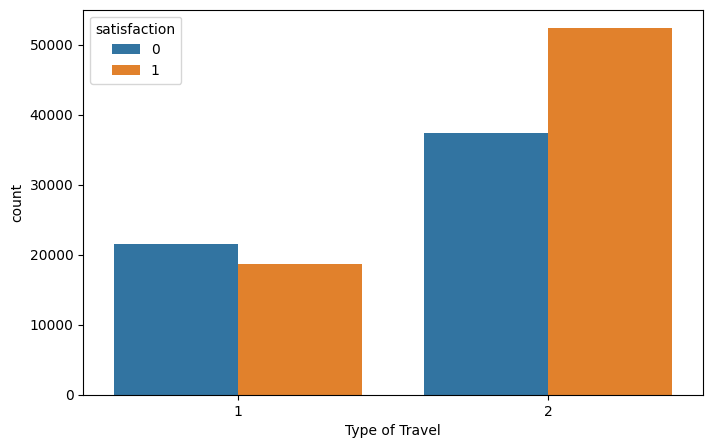

In [77]:
plt.figure(figsize=(8, 5))

x = 'Type of Travel'
y = target

sns.countplot(x=x, hue=y, data=DF)
plt.show()

Customers traveling for business are significantly more likely to be satisfied compared to those traveling for personal reasons. This suggests that the factors associated with business travel in this dataset contribute more to customer satisfaction.

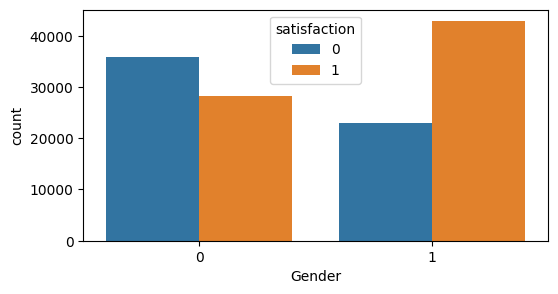

In [78]:
plt.figure(figsize=(6, 3))

x = 'Gender'
y = target

sns.countplot(x=x, hue=y, data=DF)
plt.show()

Compared to men, female passengers have higher satisfaction

**Conclusion:**

This project successfully built a CatBoost model to predict airline customer satisfaction with high accuracy (93.3%). The analysis revealed key drivers of satisfaction, particularly "Inflight entertainment", "Seat comfort", and "Type of Travel", providing valuable insights for improving customer experience.